 # Etapa 1: Limpieza de Datos
 Equipo 2

---





## Importación de Librerías

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.imputation import mice
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()


## Carga de Datos Local
En caso que sea necesario, se cargan los datos localmente desde su archivos CSV

In [52]:
# Carga de archivos
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

### Paso 1 : Limpieza de Columna "Age" y Feature Engineering con Titulo


 La columna 'Age' (Edad) es una característica importante para predecir la supervivencia en el Titanic. Las edades pueden influir en la probabilidad de supervivencia, ya que es posible que se haya dado prioridad a niños y ancianos durante el rescate. Además, la edad puede estar relacionada con otras características, como la clase del pasajero, que también pueden influir en la supervivencia.


In [53]:
# Contando los valores nulos en la columna 'Age' para ambos conjuntos

# Para el conjunto de entrenamiento (train)
null_values_train = train['Age'].isnull().sum()
print(f"Valores nulos en la columna 'Age' del conjunto de entrenamiento: {null_values_train}")

# Para el conjunto de prueba (test)
null_values_test = test['Age'].isnull().sum()
print(f"Valores nulos en la columna 'Age' del conjunto de prueba: {null_values_test}")

Valores nulos en la columna 'Age' del conjunto de entrenamiento: 177
Valores nulos en la columna 'Age' del conjunto de prueba: 86


In [54]:
# Por ello extraemos el título de la columna 'Name'
train['Title'] = train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test['Title'] = test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

#### Imputación de Train con RF

In [55]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Suponiendo que ya has cargado tus datos en las variables 'train' y 'test'
# y que ya has extraído la columna 'Title' de 'Name'

# Convertir las variables categóricas en dummies
train_dummies = pd.get_dummies(train, columns=['Title', 'Sex', 'Pclass', 'Embarked'], drop_first=True)
test_dummies = pd.get_dummies(test, columns=['Title', 'Sex', 'Pclass', 'Embarked'], drop_first=True)

# Eliminar columnas que no se utilizarán para el entrenamiento
train_dummies = train_dummies.drop(['Name', 'Ticket', 'Cabin'], axis=1)
test_dummies = test_dummies.drop(['Name', 'Ticket', 'Cabin'], axis=1)

# Alinear los conjuntos 'train_dummies' y 'test_dummies' para asegurarse de que tengan las mismas columnas
train_dummies, test_dummies = train_dummies.align(test_dummies, join='outer', axis=1, fill_value=0)

# Dividir el conjunto 'train' en registros con 'Age' y registros sin 'Age'
train_with_age = train_dummies.dropna(subset=['Age'])
train_without_age = train_dummies[train_dummies['Age'].isnull()].copy()

# Definir características y objetivo para 'train'
X_train = train_with_age.drop('Age', axis=1)
y_train = train_with_age['Age']

# Entrenar el Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predecir los valores faltantes de 'Age' en 'train'
predicted_ages_train = rf.predict(train_without_age.drop('Age', axis=1))
train_without_age.loc[:, 'Age'] = predicted_ages_train

# Asignar las edades predichas al DataFrame 'train' original
train.loc[train['Age'].isnull(), 'Age'] = predicted_ages_train

# Dividir el conjunto 'test' en registros con 'Age' y registros sin 'Age'
test_with_age = test_dummies.dropna(subset=['Age'])
test_without_age = test_dummies[test_dummies['Age'].isnull()].copy()

# Predecir los valores faltantes de 'Age' en 'test'
predicted_ages_test = rf.predict(test_without_age.drop('Age', axis=1))
test_without_age.loc[:, 'Age'] = predicted_ages_test

# Asignar las edades predichas al DataFrame 'test' original
test.loc[test['Age'].isnull(), 'Age'] = predicted_ages_test

### Paso 2 : Limpieza de Columna "Embarked"


In [56]:
# Vemos que una de ellas domina, por lo que la rellenaremos con ella

most_common_embarked = train['Embarked'].mode()[0]

train['Embarked'].fillna(most_common_embarked, inplace=True)

In [57]:
test['Fare'].fillna(test['Fare'].median(), inplace=True)

### Paso 3: Imputación de Columna "Cabin"

In [58]:
# Codificar la columna 'Cabin'
train['Cabin_encoded'] = le.fit_transform(train['Cabin'].astype(str))

# Calcular la correlación con 'Survived'
correlation = train['Survived'].corr(train['Cabin_encoded'])
print(f"Correlación entre 'Survived' y 'Cabin_encoded': {correlation:.2f}")

Correlación entre 'Survived' y 'Cabin_encoded': -0.25


In [59]:
# Extraer la primera letra de la columna 'Cabin' para obtener la cubierta
train['Deck'] = train['Cabin'].str[0]
test['Deck'] = test['Cabin'].str[0]

# Agrupar por número de ticket y llenar las cabinas faltantes con el modo (valor más común) dentro de ese grupo
train['Deck'] = train.groupby('Ticket')['Deck'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x))
test['Deck'] = test.groupby('Ticket')['Deck'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x))

# Para las cabinas que aún falten, imputarlas con 'Unknown'
train['Deck'].fillna('Unknown', inplace=True)
test['Deck'].fillna('Unknown', inplace=True)

In [60]:
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

# Modelo de Random Forest

### Modelo Base

Accuracy: 0.8268156424581006
Precision: 0.8115942028985508
Recall: 0.7567567567567568
F1 Score: 0.7832167832167832


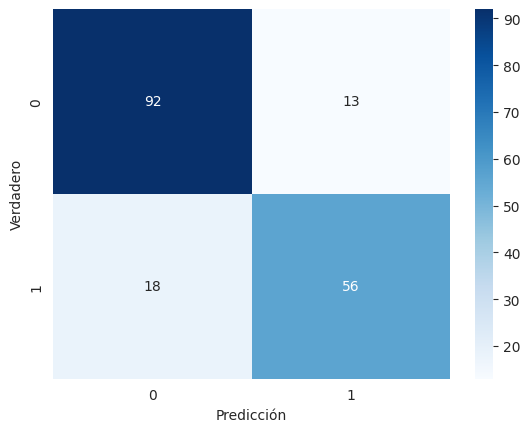

In [61]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Eliminar columnas que no se utilizarán en el modelo
X_train = train.drop(['Survived', 'Name', 'Ticket', 'Title'], axis=1)
y_train = train['Survived']
X_test = test.drop(['Name', 'Ticket', 'Title'], axis=1)  # Asumiendo que 'test' no contiene la columna 'Survived'

# Codificar variables categóricas como 'Sex' y 'Embarked'
X_train = pd.get_dummies(X_train, columns=['Sex', 'Embarked', 'Deck'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Sex', 'Embarked', 'Deck'], drop_first=True)

# Alinear los conjuntos 'X_train' y 'X_test' para asegurarse de que tengan las mismas columnas
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Dividir el conjunto de entrenamiento en subconjuntos de entrenamiento y validación
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Crear el modelo de Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=2, min_samples_split=2, bootstrap=False, random_state=42)

# Entrenar el modelo en el subconjunto de entrenamiento
rf.fit(X_train_split, y_train_split)

# Hacer predicciones en el subconjunto de validación
y_val_pred = rf.predict(X_val_split)

# Calcular métricas numéricas
accuracy = accuracy_score(y_val_split, y_val_pred)
precision = precision_score(y_val_split, y_val_pred)
recall = recall_score(y_val_split, y_val_pred)
f1 = f1_score(y_val_split, y_val_pred)

# Imprimir las métricas
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_val_split, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

# Hacer predicciones en el conjunto de prueba
y_pred = rf.predict(X_test)

# Crear el DataFrame de submission
submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_pred})

# Guardar el DataFrame de submission como un archivo CSV
submission.to_csv('submission.csv', index=False)


### Búsqueda de Mejores Hiperparámetros

In [62]:
from sklearn.model_selection import GridSearchCV

# Definir el modelo de bosque aleatorio
rf = RandomForestClassifier(random_state=42)

# Definir la grilla de hiperparámetros para buscar
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Ajustar GridSearchCV al conjunto de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Obtener el mejor modelo
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Mejores hiperparámetros: {'bootstrap': False, 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


### Modelo con Ajuste de Hiperparámetros

In [65]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Dividir el conjunto de entrenamiento en subconjuntos de entrenamiento y validación
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Entrenar el modelo en el subconjunto de entrenamiento
best_rf.fit(X_train_split, y_train_split)

# Predecir los resultados para el subconjunto de validación
y_val_pred = best_rf.predict(X_val_split)

# Calcular métricas
accuracy = accuracy_score(y_val_split, y_val_pred)
precision = precision_score(y_val_split, y_val_pred)
recall = recall_score(y_val_split, y_val_pred)
f1 = f1_score(y_val_split, y_val_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Accuracy: 0.8156
Precision: 0.7971
Recall: 0.7432
F1 Score: 0.7692
